In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import sys
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F

from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as fnn
from torchvision import transforms

root_path = './'
sys.path.append(root_path)

from hack_utils import Timer
from hack_utils import NUM_PTS
from hack_utils import ThousandLandmarksDataset, DebugThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

time: 1.06 s


# Реализуем вспомогательные функции

Обучение модели

In [3]:
def train(model, loader, loss_fn, optimizer, device, epoch, writer, scheduler):
    model.train()
    train_loss = []
    loader_len = len(loader)
    for i, batch in tqdm(enumerate(loader), total=loader_len, desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())
        writer.add_scalar('train__batch_loss', train_loss[-1], epoch*loader_len + i)
        
        scheduler.step(train_loss[-1])
        writer.add_scalar('lr_batch', optimizer.lr, epoch*loader_len + i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

time: 23.7 ms


Валидация модели

In [4]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())
        
    figure_pred(dataset=test_dataset, landmarks=test_predictions)

    return np.mean(val_loss)

time: 27.9 ms


Предсказание моделью

In [5]:
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

time: 27.2 ms


Создание названия эксперимента

In [6]:
def get_exp_name(train_params: dict, name: str = None) -> str:
    cur_time = time.strftime("%b_%d_%Y_%H:%M:%S", time.localtime())
    exp_name = f"{cur_time}__"
    if name is not None:
        exp_name += f"{name}_"
    exp_name += f"model={train_params['base_model']}_bs={train_params['batch_size']}_"\
        f"epochs={train_params['epochs']}_lr={train_params['lr']}_"\
        f"lr_decay={train_params['lr_decay']}_w_decay={train_params['weight_decay']}"
    return exp_name

time: 26.3 ms


Отрисовка предсказаний

In [7]:
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)


def tensor_image2numpy(image: torch.Tensor) -> np.ndarray:
    # revert normalization
    image = (image * std) + mean
    
    return np.array(F.to_pil_image(image))


def draw_landmarks(image: np.ndarray, landmarks: np.ndarray) -> np.ndarray:
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)

    return image


def figure_landmark_examples(images: torch.Tensor, landmarks: torch.Tensor):
    n_images = images.shape[0]
    n_cols = 4
    n_rows = n_images // n_cols + int(n_images % n_cols != 0)

    fig = plt.figure(figsize=(25, n_rows * 8))
    for i, (image, landmark) in enumerate(zip(images, landmarks), 1):
        image = tensor_image2numpy(image)
        landmark = landmark.reshape(NUM_PTS, 2).numpy()
        
        image = draw_landmarks(image, landmark)

        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.imshow(image)

    return fig

time: 29.4 ms


## Настроим аугментацию

In [41]:
from augmentation import AffineAugmenter, CropAugmenter, BrightnessContrastAugmenter, BlurAugmenter, Augmenter
from augmentation import get_i_from_dict, batch2samples, RandomAugmentation

time: 25.7 ms


64it [00:00, 406.65it/s]


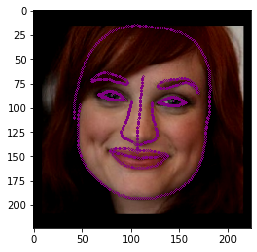

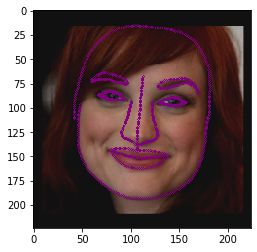

time: 709 ms


In [47]:
CROP_SIZE=224
with_inv=True

augmenter = RandomAugmentation(
    augmenters_list=[
        Augmenter(with_inv=with_inv),
        BrightnessContrastAugmenter(brightness=0.2, contrast=0.2, with_inv=with_inv),
        BlurAugmenter(max_kernel=5, with_inv=with_inv),
        CropAugmenter(min_scale=0.8, with_inv=with_inv),
        AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.1, rotate=True, with_inv=with_inv),
    ],
    probs=[0.3, 0.2, 0.2, 0.15, 0.15],
#     probs=[0.5, 0.5],
    with_inv=with_inv,
)
# augmenter = AffineAugmenter(min_scale=0.9, max_scale=1.1, max_offset=0.1, rotate=True, with_inv=with_inv)

debug_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    augmenter,
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)), 
])

debug_dataset = DebugThousandLandmarksDataset(os.path.join(data_dir, 'train'), debug_transforms)
debug_dataloader = data.DataLoader(
    debug_dataset, batch_size=10, num_workers=0, #num_workers=4, 
    pin_memory=True, shuffle=False, drop_last=False,
)

batch = next(iter(debug_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]


i = 1#9 #np.random.choice(images.shape[0])
# image = images[i].numpy()
image = tensor_image2numpy(images[i])
landmark = landmarks[i].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

sample = get_i_from_dict(i, batch)
sample['image'] = tensor_image2numpy(sample['image'])
# inv_sample = AffineAugmenter().inv(sample)
# inv_sample = CropAugmenter().inv(sample)
# inv_sample = BrightnessContrastAugmenter().inv(sample)
# inv_sample = BlurAugmenter().inv(sample)
inv_sample = augmenter.inv(sample)


image = inv_sample['image']
landmark = inv_sample['landmarks'].reshape(NUM_PTS, 2).numpy()
fig = draw_landmarks(image, landmark)

plt.imshow(fig)
plt.show()

In [23]:
t = sample['landmarks']
t

tensor([102.5724, 193.2121, 100.3098,  ...,  86.8687, 144.0539,  93.6566],
       dtype=torch.float64)

time: 27.6 ms


In [21]:
t.dtype

torch.float32

time: 27 ms


In [17]:
t.type

<function Tensor.type>

time: 27.7 ms


In [543]:
for k, v in augmenter.params_example.items():
    print(k, type(v))

angle <class 'float'>
scale <class 'float'>
x_center <class 'int'>
y_center <class 'int'>
x_offset <class 'int'>
y_offset <class 'int'>
time: 27.8 ms


In [544]:
for k, v in sample['params'].items():
    print(k, type(v), v)

angle <class 'torch.Tensor'> tensor(0., dtype=torch.float64)
scale <class 'torch.Tensor'> tensor(0.8970, dtype=torch.float64)
x_center <class 'torch.Tensor'> tensor(0)
y_center <class 'torch.Tensor'> tensor(0)
x_offset <class 'torch.Tensor'> tensor(4)
y_offset <class 'torch.Tensor'> tensor(22)
new_w <class 'torch.Tensor'> tensor(200)
new_h <class 'torch.Tensor'> tensor(200)
brightness <class 'torch.Tensor'> tensor(0., dtype=torch.float64)
contrast <class 'torch.Tensor'> tensor(0., dtype=torch.float64)
kernel <class 'torch.Tensor'> tensor(0)
time: 31.4 ms


In [477]:
sample

{'landmarks': tensor([ 96.0010, 194.2178,  93.5760,  ...,  80.2420, 140.4596,  87.5171]),
 'image': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 'scale_coef': tensor(0.7542),
 'crop_margin_x': te

time: 31.9 ms


time: 27.6 ms


In [257]:
for sample in batch2samples(batch, 10):
    print(sample)

{'landmarks': tensor([105.4216, 188.5180, 103.1896,  ...,  68.3225, 156.2376,  86.4851],
       dtype=torch.float64), 'image': tensor([[[128, 128, 128],
         [128, 128, 128],
         [128, 128, 128],
         ...,
         [128, 128, 128],
         [128, 128, 128],
         [128, 128, 128]],

        [[128, 128, 128],
         [128, 128, 128],
         [128, 128, 128],
         ...,
         [128, 128, 128],
         [128, 128, 128],
         [128, 128, 128]],

        [[128, 128, 128],
         [128, 128, 128],
         [128, 128, 128],
         ...,
         [128, 128, 128],
         [128, 128, 128],
         [128, 128, 128]],

        ...,

        [[128, 128, 128],
         [128, 128, 128],
         [128, 128, 128],
         ...,
         [128, 128, 128],
         [128, 128, 128],
         [128, 128, 128]],

        [[128, 128, 128],
         [128, 128, 128],
         [128, 128, 128],
         ...,
         [128, 128, 128],
         [128, 128, 128],
         [128, 128, 128]],


# Основная часть

In [10]:
data_dir = os.path.join(root_path, 'data')
CROP_SIZE = 224  # размер изображений во время обучения сети - feature extractor'а на ImageNet
train_params = {'batch_size': 512}

time: 25.7 ms


### Подготовим данные для обучения

Пайплайн препроцессинга изображений

In [9]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225],
    ), ("image",)),  # стандартные параметры нормализации для сетей, обученных на ImageNet
])

In [11]:
# import invertransforms as T

# transform = T.Compose([
#   T.RandomCrop(size=256),
#   T.ToTensor(),
# ])
# img_tensor = transform(img)

# # invert
# img_again = transform.invert(img_tensor)

Загрузим данные для обучения и валидации

In [14]:
with Timer() as t:
#     train_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms, split="train")
#     train_dataloader = data.DataLoader(
#         train_dataset, batch_size=train_params['batch_size'], num_workers=4, 
#         pin_memory=True, shuffle=True, drop_last=True,
#     )
    val_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'train'), train_transforms, split="val")
    val_dataloader = data.DataLoader(
        val_dataset, batch_size=train_params['batch_size'], num_workers=0, #num_workers=4, 
        pin_memory=True, shuffle=False, drop_last=False,
    )
print(f'Reading data took {t.interval:.03f} sec.')

393931it [01:49, 3602.57it/s]  

Reading data took 187.582 sec.


In [68]:
batch = next(iter(val_dataloader))
images = batch["image"]#.to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
landmarks = batch["landmarks"]

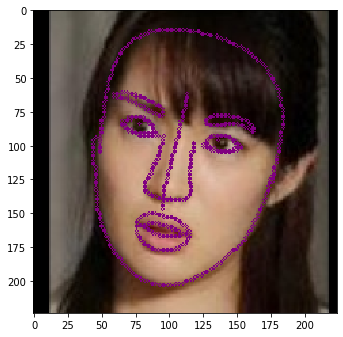

time: 384 ms


In [86]:
n_images = 1
idxs = np.random.choice(images.shape[0], size=min(n_images, images.shape[0]), replace=False)
fig = figure_landmark_examples(images=images[idxs], landmarks=landmarks[idxs])
plt.show()

## Эксперимент

Зададим параметры эксперимента

In [9]:
train_params.update({
    'base_model': 'inception_v3',
    'epochs': 10,
    'lr': 1e-2,
    'lr_decay': 0.7,
    'weight_decay': 0.01,
    'gpu': True,
})
exp_name = get_exp_name(train_params=train_params, name='baseline')
print(exp_name)
exp_dir = os.path.join(root_path, 'exp_dirs', exp_name)
os.makedirs(exp_dir)

Apr_26_2020_17:11:33__baseline_model=resnet18_bs=512_epochs=10_lr=0.01_lr_decay=0.7_w_decay=0.01


TensorBoard writer

In [10]:
writer = SummaryWriter(os.path.join(root_path, 'log_dir', exp_name))

Создадим модель

In [ ]:
del model

In [ ]:
optimizer.lr

In [11]:
device = torch.device("cuda: 0") if train_params['gpu'] else torch.device("cpu")
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=train_params['lr'],
    weight_decay=train_params['weight_decay'],
    amsgrad=True,
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=train_params['lr_decay'], patience=50,
    min_lr=1e-5,
)
loss_fn = fnn.mse_loss

Обучим и провалидируем модель

In [12]:
with Timer() as t:
    best_val_loss = np.inf
    for epoch in range(train_params['epochs']):
        train_loss = train(model, train_dataloader, loss_fn, optimizer, 
                           device=device, epoch=epoch, writer=writer, scheduler=scheduler)
        writer.add_scalar('train_loss', train_loss, epoch)
        
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        writer.add_scalar('val_loss', val_loss, epoch)
        
        print(f"Epoch #{epoch:2}:\ttrain loss: {train_loss:5.2}\tval loss: {val_loss:5.2}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join(exp_dir, "best_model.pth"), "wb") as fp:
                torch.save(model.state_dict(), fp)

print(f'Training model took {t.interval:.03f} sec.')


Epoch # 0:	train loss: 2.3e+02	val loss: 1.9e+01



Epoch # 1:	train loss: 1.4e+01	val loss: 1.2e+01


KeyboardInterrupt: 

# Предсказание

Загрузим тестовые данные

In [14]:
with Timer() as t:
    test_dataset = ThousandLandmarksDataset(os.path.join(data_dir, 'test'), train_transforms, split="test")
    test_dataloader = data.DataLoader(
        test_dataset, batch_size=train_params['batch_size'], num_workers=4, 
        pin_memory=True, shuffle=False, drop_last=False,
    )
print(f'Reading data took {t.interval:.03f} sec.')



0it [00:00, ?it/s]

45629it [00:00, 456276.29it/s]

99820it [00:00, 455697.18it/s]

Reading data took 0.250 sec.


In [15]:
with Timer() as t:
    with open(os.path.join(exp_dir, "best_model.pth"), "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        model.load_state_dict(best_state_dict)

    test_predictions = predict(model, test_dataloader, device)
    with open(os.path.join(exp_dir, "test_predictions.pkl"), "wb") as fp:
        pickle.dump({
                "image_names": test_dataset.image_names,
                "landmarks": test_predictions
            }, 
            fp,
        )

    create_submission(data_dir, test_predictions, os.path.join(exp_dir, "submit.csv"))
print(f'Test prediction took {t.interval:.03f} sec.')


Test prediction took 308.658 sec.
